In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_classif


In [2]:
df = pd.read_csv("../data/chargeback_data_final.csv")
df

,dia,dia_semana,periodo_semana,periodo_mes,hora,hora_completa_segundos,periodo_dia,cartao,valor,media_dia,media_cartao,total_uso_cartao,cbk,vez_uso_cartao,cartao_usado_antes
0,1,4,semana,inicio,0,114,madrugada,536518******2108,36.54,139.59,36.54,2,Não,1,False
1,1,4,semana,inicio,0,226,madrugada,536518******2108,36.54,139.59,36.54,2,Não,2,True
2,1,4,semana,inicio,0,530,madrugada,453211******1239,69.00,139.59,69.00,1,Não,1,False
3,1,4,semana,inicio,0,1620,madrugada,548827******1705,193.43,139.59,193.43,1,Não,1,False
4,1,4,semana,inicio,1,5566,madrugada,531681******9778,132.00,139.59,132.00,1,Não,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999,30,5,fds,fim,23,83327,noite,439354******5281,15.00,95.18,15.00,1,Não,1,False
11000,30,5,fds,fim,23,83724,noite,549167******1648,20.00,95.18,20.00,1,Não,1,False
11001,30,5,fds,fim,23,83861,noite,518759******8384,70.00,95.18,70.00,1,Não,1,False
11002,30,5,fds,fim,18,66573,tarde,455188******5104,2.10,95.18,2.10,1,Não,1,False


### Comparando modelos

In [3]:
def compare_models(featrues, target):    
    # prepare models
    models = []
    models.append(('LR', LogisticRegression(max_iter=1000)))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GNB', GaussianNB()))
    models.append(('BNB', BernoulliNB()))
    models.append(('SVM', SVC()))
    models.append(('RFC', RandomForestClassifier()))
    models.append(('XGB', XGBClassifier()))
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    X2 = featrues.copy()

    # label encoding
    le = LabelEncoder()
    for x in ['periodo_semana', 'periodo_mes', 'periodo_dia']:
        X2[x] = le.fit_transform(X2[x])

    y_labeled = le.fit_transform(target)

    X_scaled = StandardScaler().fit_transform(X2)


    for name, model in models:
        kfold = KFold(n_splits=10, random_state=None)
        cv_results = cross_val_score(model, X2, y_labeled, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [20]:
features_list = ['dia', 'hora', 'dia_semana', 'periodo_semana', 'periodo_mes',
       'hora_completa_segundos', 'periodo_dia', 'valor', 'cartao_usado_antes']

# Separando as features e o target
# Sem usar media_dia, media_cartao e quantidade_uso_cartao para não ter data leakage
X = df.loc[:,features_list]
y = df['cbk']

# Dividindo o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# label encoding
le = LabelEncoder()
for x in ['periodo_semana', 'periodo_mes', 'periodo_dia', 'cartao_usado_antes']:
    X_train[x] = le.fit_transform(X_train[x])
    X_test[x] = le.transform(X_test[x])

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


LR: 0.947106 (0.018344)
KNN: 0.943562 (0.015899)
DTC: 0.919205 (0.017633)
GNB: 0.937742 (0.031483)
BNB: 0.947378 (0.016912)
SVM: 0.948469 (0.016333)
RFC: 0.948832 (0.015897)
XGB: 0.945652 (0.016062)


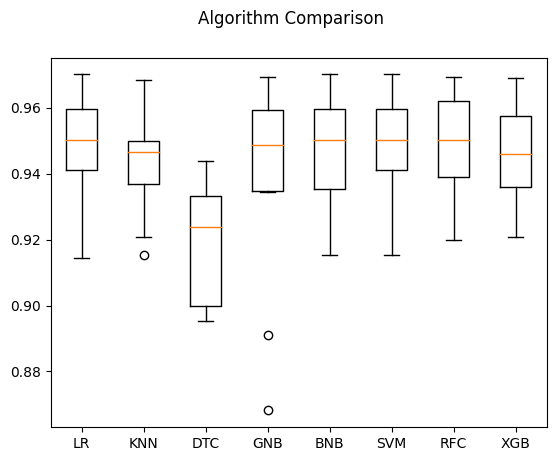

In [5]:
compare_models(X, y)

### Random Forest Classifier

In [44]:
param_grid = { 
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'criterion' : ['gini', 'entropy', 'log_loss'], 
    'min_samples_split' : [2, 3, 4, 5], 
    'min_samples_leaf': [1, 2, 3, 4]
}

rfc2=RandomForestClassifier(random_state=42)
rf_RandomGrid = RandomizedSearchCV(estimator = rfc2, param_distributions = param_grid, cv = 10, n_jobs = 4, scoring='recall')
rf_RandomGrid.fit(X_train, y_train)

rf_RandomGrid.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'criterion': 'entropy'}

In [21]:
# Criando o modelo Random Forest
rf = RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 300, criterion='entropy')

# Treinando o modelo
rf.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = rf.predict(X_test)

# Avaliando o modelo
print('Acurácia: ', accuracy_score(y_test, y_pred))
print('Precisão: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1-Score: ', f1_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Acurácia:  0.9763743752839619
Precisão:  0.8888888888888888
Recall:  0.5925925925925926
F1-Score:  0.711111111111111
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2093
           1       0.89      0.59      0.71       108

    accuracy                           0.98      2201
   macro avg       0.93      0.79      0.85      2201
weighted avg       0.97      0.98      0.97      2201



In [6]:
confusion_matrix(y_test, y_pred)

array([[2085,    8],
       [  44,   64]])

Best Threshold=0.510000, F-Score=0.711


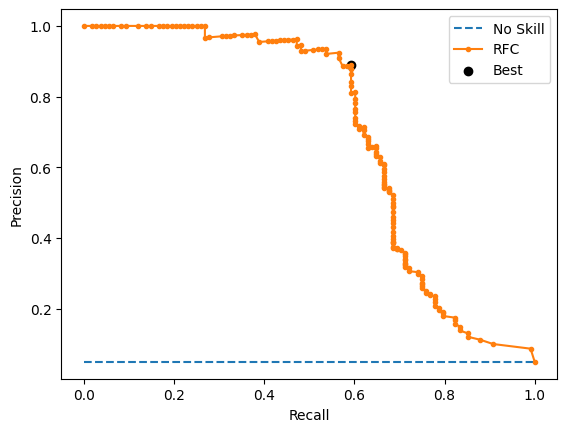

In [6]:
# predict probabilidade
y_prob = rf.predict_proba(X_test)
y_prob = y_prob[:, 1]

# Calculando precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
# convertendo para f score
fscore = (2 * precision * recall) / (precision + recall)
# pegando o index com maior f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plotando precision recall curve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='RFC')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [10]:
threshold = 0.51

predicted_proba = rf.predict_proba(X_test)
y_pred_proba = (predicted_proba [:,1] >= threshold).astype('int')

# Avaliando o modelo
print('Acurácia: ', accuracy_score(y_test, y_pred_proba))
print('Precisão: ', precision_score(y_test, y_pred_proba))
print('Recall: ', recall_score(y_test, y_pred_proba))
print('F1-Score: ', f1_score(y_test, y_pred_proba))

print(classification_report(y_test, y_pred_proba))

Acurácia:  0.9763743752839619
Precisão:  0.8888888888888888
Recall:  0.5925925925925926
F1-Score:  0.711111111111111
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2093
           1       0.89      0.59      0.71       108

    accuracy                           0.98      2201
   macro avg       0.93      0.79      0.85      2201
weighted avg       0.97      0.98      0.97      2201



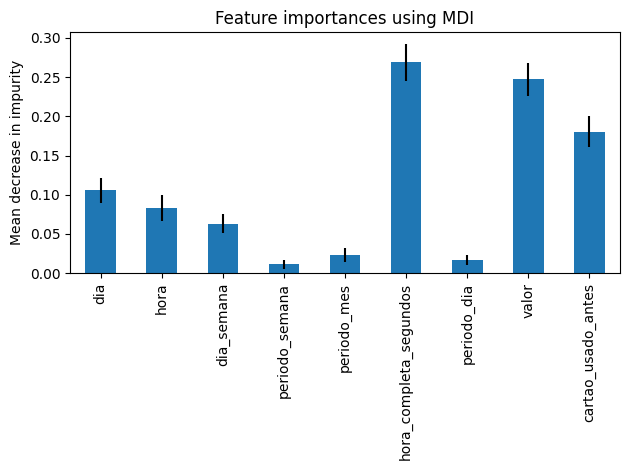

In [22]:
# Feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
feature_names = [X.columns[i] for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Testando transformando variáveis ​​cíclicas

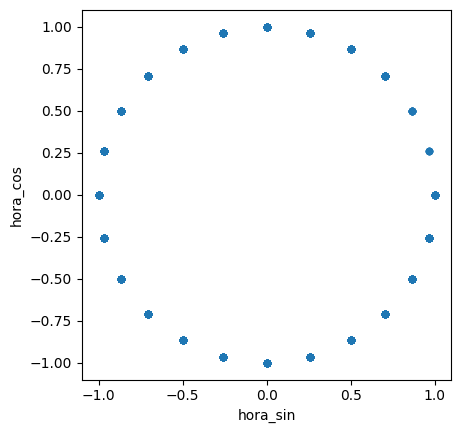

In [8]:
df['dia_sin'] = np.sin(2 * np.pi * df['dia']/30)
df['dia_cos'] = np.cos(2 * np.pi * df['dia']/30)
df['hora_sin'] = np.sin(2 * np.pi * df['hora']/24.0)
df['hora_cos'] = np.cos(2 * np.pi * df['hora']/24.0)
df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana']/7)
df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana']/7)

ax = df.plot.scatter('hora_sin', 'hora_cos').set_aspect('equal')

In [39]:
features_list2 = ['dia_sin', 'dia_cos', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 'periodo_semana', 'periodo_mes',
       'hora_completa_segundos', 'periodo_dia', 'valor', 'cartao_usado_antes']

# Separando as features e o target
# Sem usar media_dia, media_cartao e quantidade_uso_cartao para não ter data leakage
X2 = df.loc[:,features_list2]
y2 = df['cbk']

# Dividindo o conjunto de dados em treinamento e teste
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# label encoding
le = LabelEncoder()
for x in ['periodo_semana', 'periodo_mes', 'periodo_dia', 'cartao_usado_antes']:
    X_train2[x] = le.fit_transform(X_train2[x])
    X_test2[x] = le.transform(X_test2[x])

y_train2 = le.fit_transform(y_train2)
y_test2 = le.transform(y_test2)


param_grid = { 
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'criterion' : ['gini', 'entropy', 'log_loss'], 
    'min_samples_split' : [2, 3, 4, 5], 
    'min_samples_leaf': [1, 2, 3, 4]
}

rfc2=RandomForestClassifier(random_state=42)
rf_RandomGrid = RandomizedSearchCV(estimator = rfc2, param_distributions = param_grid, cv = 10, n_jobs = 4, scoring='recall')
rf_RandomGrid.fit(X_train2, y_train2)

rf_RandomGrid.best_params_

{'n_estimators': 300,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'criterion': 'gini'}

In [40]:
# Criando o modelo Random Forest
rf2 = RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 200, criterion='log_loss', min_samples_split=4)

# Treinando o modelo
rf2.fit(X_train2, y_train2)

# Fazendo previsões no conjunto de teste
y_pred2 = rf2.predict(X_test2)

# Avaliando o modelo
print('Acurácia: ', accuracy_score(y_test2, y_pred2))
print('Precisão: ', precision_score(y_test2, y_pred2))
print('Recall: ', recall_score(y_test2, y_pred2))
print('F1-Score: ', f1_score(y_test2, y_pred2))

print(classification_report(y_test2, y_pred2))

Acurácia:  0.9750113584734211
Precisão:  0.9491525423728814
Recall:  0.5185185185185185
F1-Score:  0.6706586826347305
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2093
           1       0.95      0.52      0.67       108

    accuracy                           0.98      2201
   macro avg       0.96      0.76      0.83      2201
weighted avg       0.97      0.98      0.97      2201



Best Threshold=0.448520, F-Score=0.694


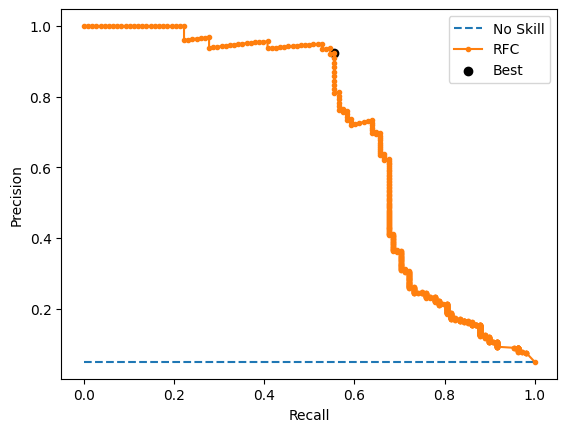

In [41]:
# predict probabilidade
y_prob2 = rf2.predict_proba(X_test2)
y_prob2 = y_prob2[:, 1]

# Calculando precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test2, y_prob2)
# convertendo para f score
fscore = (2 * precision * recall) / (precision + recall)
# pegando o index com maior f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plotando precision recall curve
no_skill = len(y_test2[y_test2==1]) / len(y_test2)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='RFC')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [43]:
threshold = 0.45

predicted_proba2 = rf2.predict_proba(X_test2)
y_pred_proba2 = (predicted_proba2 [:,1] >= threshold).astype('int')

# Avaliando o modelo
print('Acurácia: ', accuracy_score(y_test2, y_pred_proba2))
print('Precisão: ', precision_score(y_test2, y_pred_proba2))
print('Recall: ', recall_score(y_test2, y_pred_proba2))
print('F1-Score: ', f1_score(y_test2, y_pred_proba2))

print(classification_report(y_test2, y_pred_proba2))

Acurácia:  0.975465697410268
Precisão:  0.921875
Recall:  0.5462962962962963
F1-Score:  0.686046511627907
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2093
           1       0.92      0.55      0.69       108

    accuracy                           0.98      2201
   macro avg       0.95      0.77      0.84      2201
weighted avg       0.97      0.98      0.97      2201



#### Oversampling

In [44]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))

oversample = SMOTE(random_state=42)
X_train_o, y_train_o = oversample.fit_resample(X_train,y_train)
print('Resampled dataset shape %s' % Counter(y_train_o))

Original dataset shape Counter({0: 8344, 1: 459})
Resampled dataset shape Counter({0: 8344, 1: 8344})


In [46]:
param_grid = { 
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'criterion' : ['gini', 'entropy', 'log_loss'], 
    'min_samples_split' : [2, 3, 4, 5], 
    'min_samples_leaf': [1, 2, 3, 4]
}

rfc2=RandomForestClassifier(random_state=42)
rf_RandomGrid = RandomizedSearchCV(estimator = rfc2, param_distributions = param_grid, cv = 10, n_jobs = 4, scoring='recall')
rf_RandomGrid.fit(X_train_o, y_train_o)

rf_RandomGrid.best_params_

{'n_estimators': 50,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'criterion': 'gini'}

In [48]:
# Criando o modelo Random Forest
rf_o = RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 50, criterion='gini', min_samples_split=4, min_samples_leaf=1)

# Treinando o modelo
rf_o.fit(X_train_o, y_train_o)

# Fazendo previsões no conjunto de teste
y_pred_o = rf_o.predict(X_test)

# Avaliando o modelo
print('Acurácia: ', accuracy_score(y_test, y_pred_o))
print('Precisão: ', precision_score(y_test, y_pred_o))
print('Recall: ', recall_score(y_test, y_pred_o))
print('F1-Score: ', f1_score(y_test, y_pred_o))

print(classification_report(y_test, y_pred_o))

Acurácia:  0.9482053611994548
Precisão:  0.4785714285714286
Recall:  0.6203703703703703
F1-Score:  0.5403225806451613
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2093
           1       0.48      0.62      0.54       108

    accuracy                           0.95      2201
   macro avg       0.73      0.79      0.76      2201
weighted avg       0.96      0.95      0.95      2201



### Prevendo novas transações

In [ ]:
# Carregando o data frame
df_pred = pd.read_excel("../data/chargeback_data.xlsx", sheet_name=1)
df_pred

In [ ]:
def get_day_period(time):
    period = ""
    if 6 <= time <= 12:
        period = "manha"
    elif 13 <= time <= 18:
        period = "tarde"
    elif 19 <= time <= 23:
        period = "noite"
    elif 00 <= time <= 5:
        period = "madrugada"
    return period

def get_month_period(day):
    period = ""
    if 1 <= day <= 10:
        period = "inicio"
    elif 11 <= day <= 20:
        period = "meio"
    elif 21 <= day <= 31:
        period = "fim"
    return period

def get_week_period(day):
    period = ""
    if day in range(0,5):
        period = "semana"
    else:
        period = "fds"

    return period


df_pred_pre = df_pred.copy()
df_pred_pre.columns= df_pred_pre.columns.str.lower()
df_pred_pre.rename(columns={"dia":"data", "hora":"hora_completa"}, inplace=True)

df_pred_pre.loc[:, "dia"] = pd.to_datetime(df_pred_pre.loc[:, "data"]).dt.day.astype(int)
df_pred_pre.loc[:, "periodo_mes"] = df_pred_pre.loc[:, "dia"].apply(lambda x: get_month_period(x))
df_pred_pre.loc[:, "dia_semana"] = pd.to_datetime(df_pred_pre.loc[:, "data"]).dt.day_of_week.astype(int)
df_pred_pre.loc[:, "periodo_semana"] = df_pred_pre.loc[:, "dia_semana"].apply(lambda x: get_week_period(x))
df_pred_pre.loc[:, "hora"] = df_pred_pre.loc[:, "hora_completa"].apply(lambda x: x.hour)
df_pred_pre.loc[:, "hora_completa_segundos"] = df_pred_pre.loc[:, "hora_completa"].apply(lambda x: (x.hour * 60 + x.minute) * 60 + x.second)
df_pred_pre.loc[:, "periodo_dia"] = df_pred_pre.loc[:, "hora"].apply(lambda x: get_day_period(x))


df_pred_pre_final = df_pred_pre.loc[:, ['dia','dia_semana', 'periodo_semana', 'periodo_mes', 'hora_completa_segundos', 'periodo_dia', 'valor', 'cbk']] 

In [ ]:
df_pred_pre_final

#### Previsão do modelo

In [ ]:
# label encoding
le = LabelEncoder()
for x in ['periodo_semana', 'periodo_mes', 'periodo_dia', 'cbk']:
    df_pred_pre_final[x] = le.fit_transform(df_pred_pre_final[x])

X = df_pred_pre_final.loc[:,:'valor']


# Fazendo previsões
threshold = 0.43

predicted_proba = rf.predict_proba(X)
y_pred = (predicted_proba [:,1] >= threshold).astype('int')

In [ ]:
len(predicted_proba)

In [ ]:
import collections
collections.Counter(y_pred)

In [ ]:
# Populando 
df_pred.loc[:,'CBK'] = y_pred
df_pred.replace({"CBK": {0.0: "Não",
                         1.0: "Sim",}},inplace=True)

In [ ]:
df_pred

In [ ]:
df_pred['CBK'].value_counts(normalize=True)

In [ ]:
df_pred['CBK'].value_counts(normalize=True).plot(kind="bar")
plt.title('Quantidade de chargeback')
plt.xlabel('chargeback')
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

In [ ]:
df_pred.to_csv("../data/predicted_chargeback_data.csv", index=False)